In [1]:
#Imports
import matplotlib.pyplot as plt
import pandas as pd

from helpers.hurricane_helpers import (
    get_hurricane_bin_midpoint_times,
    get_hurricane_bin_start_times,
    get_hurricane_bin_end_times
)

In [2]:
def nautical_miles_to_meters(nautical_miles):
    """
    Converts a distance in nautical miles to meters.

    Args:
        nautical_miles (float or int): The distance in nautical miles.

    Returns:
        float: The equivalent distance in meters.
    """
    conversion_factor = 1852
    meters = nautical_miles * conversion_factor
    return meters


In [3]:
def pull_hurricane_data(all_hurricanes, hurricane_name):
    # Select specific hurricane and pull corresponding data
    specific_hurricane = all_hurricanes[all_hurricanes['name'] == hurricane_name]
    hurricane_code = specific_hurricane['code'].values[0]
    hurricane_year = specific_hurricane['year'].values[0]

    glm_df = pd.read_csv(f"data/storms/{hurricane_name}_{hurricane_year}/glm/groups.csv", parse_dates=['Group Time'])
    best_track_df = pd.read_csv(f'data/storms/{hurricane_name}_{hurricane_year}/hurricane/besttrack.csv', parse_dates=['Timestamp'])
    return hurricane_code, hurricane_year, glm_df, best_track_df


In [4]:
def get_lightining_groups(bin_times, bin_starts, bin_ends, best_track_df, glm_df):
    # Get lightning group counts for each bin of histogram
    lightning_groups_inner_core = []
    lightning_groups_outer_core = []

    for idx in range(len(bin_times)):
        bin_time = bin_times[idx]
        #print(bin_time)
        bin_start = bin_starts[idx]
        bin_end = bin_ends[idx]

        try:
            # get RMW at bin time
            rmw_nautical = best_track_df[best_track_df['Timestamp'] == bin_time]['Radius of Maximum Winds'].values[0]
            rmw_meters = nautical_miles_to_meters(rmw_nautical)
            inner_core_filter = 1.5*rmw_meters
            outer_core_filter = 5*rmw_meters
            # filter bin time
            filter_glm_data = glm_df[(glm_df["Group Time"] >= bin_start) & (glm_df["Group Time"] < bin_end)]
            # filter data to only include lightning within 400 km of hurricane center
            filter_glm_data_inner_core = filter_glm_data[filter_glm_data["Distance From Hurricane Center (m)"] <= inner_core_filter]
            filter_glm_data_outer_core = filter_glm_data[(filter_glm_data["Distance From Hurricane Center (m)"] > inner_core_filter) & (filter_glm_data["Distance From Hurricane Center (m)"] <= outer_core_filter)]
            num_groups_inner_core = len(filter_glm_data_inner_core)
            num_groups_outer_core = len(filter_glm_data_outer_core)
            #print(num_groups)
            lightning_groups_inner_core.append([bin_time,num_groups_inner_core])
            lightning_groups_outer_core.append([bin_time,num_groups_outer_core])
        except:
            print('No Lightning')

    lightning_groups_inner_core_df = pd.DataFrame(lightning_groups_inner_core, columns=["time", "groups"])
    lightning_groups_outer_core_df = pd.DataFrame(lightning_groups_outer_core, columns=["time", "groups"])
    return lightning_groups_inner_core_df, lightning_groups_outer_core_df

In [23]:
def create_histogram(lightning_groups_inner_core_df,lightning_groups_outer_core_df,best_track_df,hurricane_name,hurricane_year):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
    fig.suptitle(f"{hurricane_name} {hurricane_year}: GLM Groups", fontsize=16)

    # Helper to draw one panel
    def plot_panel(ax, lightning_df, title):
        # Left axis: GLM group count
        ax.bar(
            lightning_df['time'],
            lightning_df['groups'],
            width=0.03,
            color='tab:blue',
            label='GLM Groups'
        )
        ax.set_title(title)
        ax.set_ylabel('Group Count')
        ax.tick_params(axis='x', labelrotation=90)

        # Right axis 1: Pressure
        ax_r1 = ax.twinx()
        ax_r1.plot(
            best_track_df['Timestamp'],
            best_track_df['Minimum Pressure'],
            color='tab:green',
            linewidth=1,
            label='Pressure (mb)'
        )
        ax_r1.set_ylim(800, 1100)
        ax_r1.set_ylabel('Pressure (mb)', color='tab:green')

        # Right axis 2: Wind speed
        ax_r2 = ax.twinx()
        ax_r2.plot(
            best_track_df['Timestamp'],
            best_track_df['Maximum Sustained Winds'],
            color='tab:red',
            linewidth=1,
            label='Sustained Wind (knots)'
        )
        ax_r2.set_ylim(0, 200)
        ax_r2.set_ylabel('Sustained Wind (knots)', color='tab:red')
        ax_r2.spines['right'].set_position(('outward', 60))

         # Right axis 3: RMW
        ax_r3 = ax.twinx()
        ax_r3.plot(
            best_track_df['Timestamp'],
            best_track_df['Radius of Maximum Winds'],
            color='tab:purple',
            linewidth=1,
            label='RMW (nautical miles)'
        )
        ax_r3.set_ylim(0, 200)
        ax_r3.set_ylabel('RMW (nautical miles)', color='tab:purple')
        ax_r3.spines['right'].set_position(('outward', 120))

        # Combined legend
        lines, labels = [], []
        for a in [ax, ax_r1, ax_r2, ax_r3]:
            l, lab = a.get_legend_handles_labels()
            lines.extend(l)
            labels.extend(lab)
        ax.legend(lines, labels, loc='best')

    # Left subplot: Inner core
    plot_panel(axes[0], lightning_groups_inner_core_df, "r <= 1.5RMW")

    # Right subplot: Outer core
    plot_panel(axes[1], lightning_groups_outer_core_df, "1.5RMW < r <= 5RMW")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [24]:
# Get all hurricane information
all_hurricanes = pd.read_csv("data/global/hurricane/atl_hurricane_list_20210101_20231231.csv")

## Main Code: Update hurricane name to run for different hurricanes

In [25]:
## Specify the hurricane name
hurricane_name = "IAN"
hurricane_code, hurricane_year, glm_df, best_track_df = pull_hurricane_data(all_hurricanes, hurricane_name)

In [26]:
# initialize bin times 
bin_times = get_hurricane_bin_midpoint_times(hurricane_code, region="atl", time_interval=30)
bin_starts = get_hurricane_bin_start_times(hurricane_code, region="atl", time_interval=30)
bin_ends = get_hurricane_bin_end_times(hurricane_code, region="atl", time_interval=30)

In [27]:
# Get Lightning group dataframe for each bin time
lightning_groups_inner_core_df, lightning_groups_outer_core_df = get_lightining_groups(bin_times, bin_starts, bin_ends, best_track_df, glm_df)

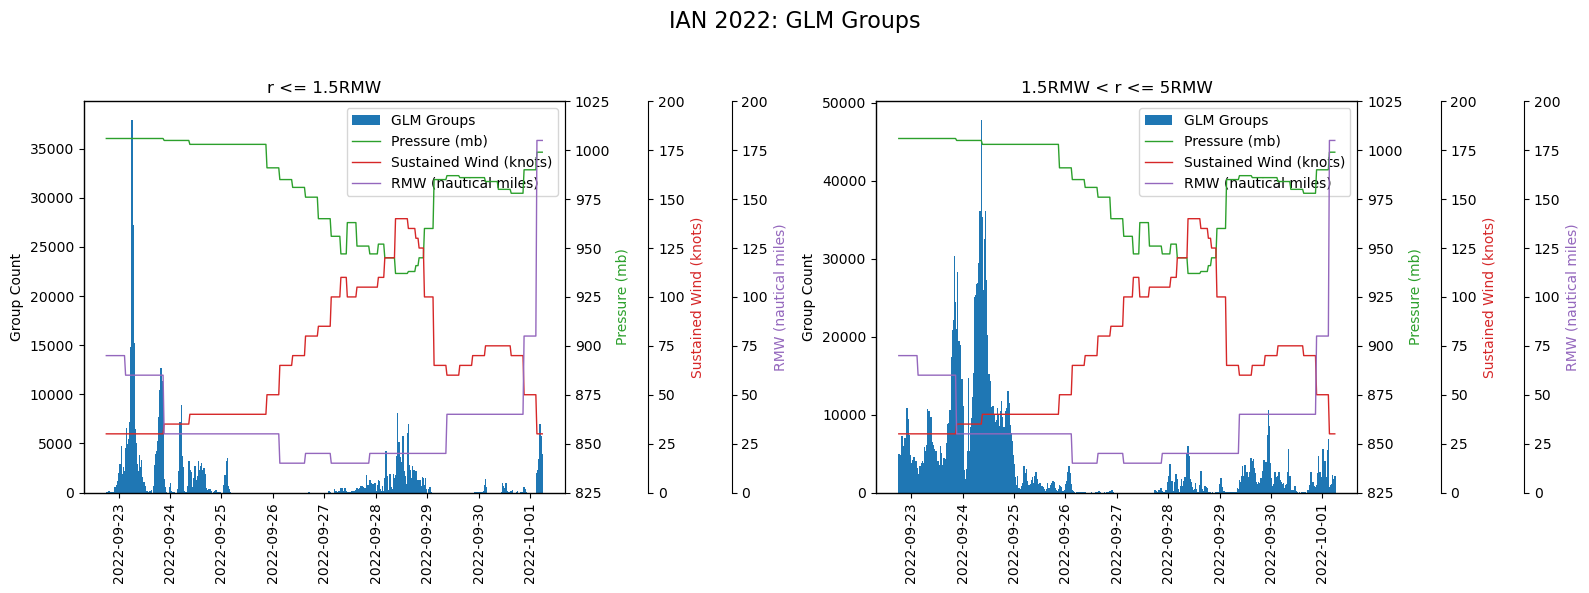

In [28]:
create_histogram(lightning_groups_inner_core_df,lightning_groups_outer_core_df,best_track_df,hurricane_name,hurricane_year)

## Old Code
### Used for single plot at a time

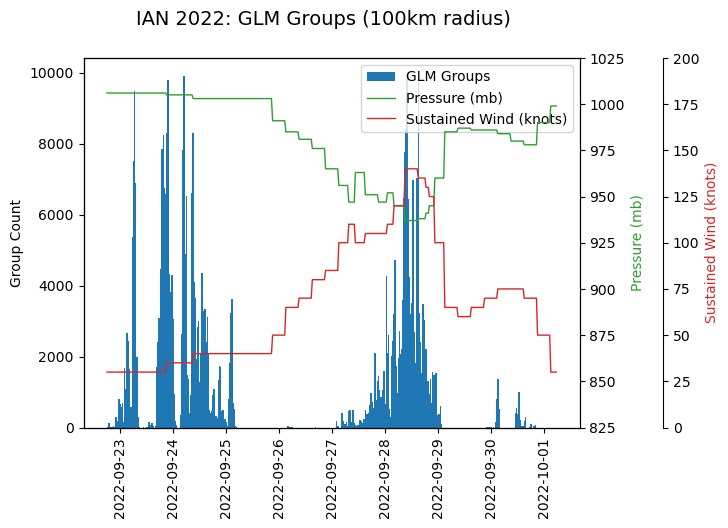

In [46]:
fig, ax = plt.subplots()

fig.suptitle(f"{hurricane_name} {hurricane_year}: GLM Groups", fontsize=14)

# Left axis: group count
ax.bar(
    lightning_groups_inner_core_df['time'], ## change to be lightning_groups_rainbands_df when desired 
    lightning_groups_inner_core_df['groups'],  ## change to be lightning_groups_rainbands_df when desired 
    width=0.03,          # tune based on time resolution
    color='tab:blue',
    label='GLM Groups'
)
ax.set_ylabel('Group Count')
ax.tick_params(axis='y')
ax.tick_params(axis='x', labelrotation=90)

# Right axis 1: pressure
ax_r1 = ax.twinx()
ax_r1.plot(
    best_track_df['Timestamp'],
    best_track_df['Minimum Pressure'],
    color='tab:green',
    label='Pressure (mb)',
    linewidth=1
)
ax_r1.set_ylim(825, 1025)
ax_r1.set_ylabel('Pressure (mb)', color='tab:green')
ax_r1.tick_params(axis='y')

# Right axis 2: wind speed
ax_r2 = ax.twinx()
ax_r2.plot(
    best_track_df['Timestamp'],
    best_track_df['Maximum Sustained Winds'],
    color='tab:red',
    label='Sustained Wind (knots)',
    linewidth=1
)
ax_r2.set_ylim(0, 200)
ax_r2.set_ylabel('Sustained Wind (knots)', color='tab:red')
ax_r2.tick_params(axis='y')
ax_r2.spines['right'].set_position(('outward', 60))

lines = []
labels = []

for a in [ax, ax_r1, ax_r2]:
    l, lab = a.get_legend_handles_labels()
    lines.extend(l)
    labels.extend(lab)

ax.legend(lines, labels, loc='best')


plt.show()